In [3]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import seed, gauss

In [4]:
# Generate a time series vector
def time_series(srate, start_time=-1, end_time=1):
    """Returns a time series vector
       Parameters
    ----------
    srate: int or float
        Sampling rate of the signal in Hz
    
    start_time: int or float
        Start time of the signal. Defaults to -1
        
    end_time: int or float
        End time of the signal. Defaults to 1
    
    Returns
    -------
    time_series: ndarray
        The time series vector
    """
    time_series = np.arange(start_time, end_time + 1 / srate, 1 / srate)
    return time_series

# Generate a sine wave
def get_sine_wave(frequency, srate, amplitude=1, start_time=-1, end_time=1, phase=0, cos=False, complex_wave=False):
    """Returns a simulated sine wave
    
    Parameters
    ----------
    frequency: int or float
        Frequency of the sine wave
        
    srate: int or float
        Sampling rate of the signal in Hz
        
    amplitude: int or float
        Amplitude of the sine wave. Defaults to 1
    
    start_time: int or float
        Start time of the signal. Defaults to -1
        
    end_time: int or float
        End time of the signal. Defaults to 1
        
    phase: int or float
        The phase angle offset of the sine wave. Defaults to 0
        
    cos: bool
        If True, generate a cosine wave instead of a sine wave. Defaults to False
    
    complex_wave: bool
        If True, generate a complex sine wave instead of a real sine wave. Defaults to False
    
    Returns
    -------
    sine_wave: ndarray
        The simulated sine wave
    """
    time = np.arange(start_time, end_time + 1 / srate, 1 / srate)
    if cos == True:
        sine_wave = amplitude * np.cos(2 * np.pi * frequency * time + phase)
    elif complex_wave == True:
        sine_wave = np.exp(2 * 1j * np.pi * frequency * time + phase)
    else: 
        sine_wave = amplitude * np.sin(2 * np.pi * frequency * time + phase)
    return sine_wave

In [5]:
# Simulation parameters
time_points = 500
n_chan = 64
n_subj = 100

# Initialize output
out = np.zeros((n_subj, n_chan, time_points+1))
out_list = []

#Noise Mu and Sigma
mu = 0
sigma = 3

# Set seed
seed(2)
series = np.random.normal(mu, sigma, (n_subj, n_chan, time_points+1))

for i in range(n_subj):
    for j in range(n_chan):
        # Generate sine waves for each channel
        sin = get_sine_wave(frequency=10, srate=1000, amplitude=1, 
                        start_time=0, end_time=.5)
        # Gaussian noise for each draw
        noise = series[i,j,:]
        
        # Add noise to the signal and store in output
        out[i, j, :] = sin + noise

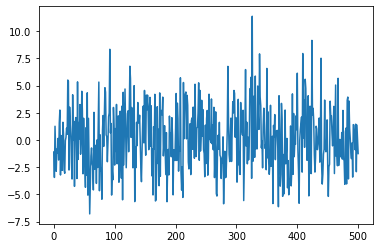

In [6]:
plt.plot(out[1,9])

In [5]:
out.shape

(100, 64, 501)

In [10]:
import logging

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import assert_all_finite
from sklearn.utils.validation import NotFittedError

__all__ = [
    "RSRM"
]

logger = logging.getLogger(__name__)


class RSRM(BaseEstimator, TransformerMixin):
    """Robust Shared Response Model (RSRM)
    Given multi-subject data, factorize it as a shared response R among all
    subjects, an orthogonal transform W per subject, and an individual
    (outlying) sparse component S per subject:
    .. math:: X_i \\approx W_i R + S_i, \\forall i=1 \\dots N
    This unsupervised model allows to learn idiosyncratic information for
    subjects and simultaneously improve the shared response estimation.
    The model has similar properties to the Shared Response Model (SRM) with
    the addition of the individual components.
    The model is estimated solving the following optimization problem:
    .. math::
        \\min_{W_i, S_i, R}\\sum_i \\frac{1}{2}\\|X_i - W_i R - S_i\\|_F^2
    .. math:: + \\gamma\\|S_i\\|_1
    .. math:: s.t. \\qquad W_i^TW_i = I \\quad \\forall i=1 \\dots N
    The solution to this problem is obtained by applying a Block-Coordinate
    Descent procedure. More details can be found in [Turek2017]_.
    Parameters
    ----------
    n_iter : int, default: 10
        Number of iterations to run the algorithm.
    features : int, default: 50
        Number of features to compute.
    gamma : float, default: 1.0
        Regularization parameter for the sparseness of the individual
        components. Higher values yield sparser individual components.
    rand_seed : int, default: 0
        Seed for initializing the random number generator.
    Attributes
    ----------
    w_ : list of array, element i has shape=[voxels_i, features]
        The orthogonal transforms (mappings) for each subject.
    r_ : array, shape=[features, timepoints]
        The shared response.
    s_ : list of array, element i has shape=[voxels_i, timepoints]
        The individual components for each subject.
    random_state_: `RandomState`
        Random number generator initialized using rand_seed
    Note
    ----
        The number of voxels may be different between subjects. However, the
        number of timepoints for the alignment data must be the same across
        subjects.
        The Robust Shared Response Model is approximated using the
        Block-Coordinate Descent (BCD) algorithm proposed in [Turek2017]_.
        This is a single node version.
    """

    def __init__(self, n_iter=10, features=50, gamma=1.0, rand_seed=0):
        self.n_iter = n_iter
        self.features = features
        self.gamma = gamma
        self.rand_seed = rand_seed

    def fit(self, X):
        """Compute the Robust Shared Response Model
        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, timepoints]
            Each element in the list contains the fMRI data of one subject.
        """
        logger.info('Starting RSRM')

        # Check that the regularizer value is positive
        if 0.0 >= self.gamma:
            raise ValueError("Gamma parameter should be positive.")

        # Check the number of subjects
        if len(X) <= 1:
            raise ValueError("There are not enough subjects in the input "
                             "data to train the model.")

        # Check for input data sizes
        if X[0].shape[1] < self.features:
            raise ValueError(
                "There are not enough timepoints to train the model with "
                "{0:d} features.".format(self.features))

        # Check if all subjects have same number of TRs for alignment
        number_trs = X[0].shape[1]
        number_subjects = len(X)
        for subject in range(number_subjects):
            assert_all_finite(X[subject])
            if X[subject].shape[1] != number_trs:
                raise ValueError("Different number of alignment timepoints "
                                 "between subjects.")

        # Create a new random state
        self.random_state_ = np.random.RandomState(self.rand_seed)

        # Run RSRM
        self.w_, self.r_, self.s_ = self._rsrm(X)

        return self

    def transform(self, X):
        """Use the model to transform new data to Shared Response space
        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, timepoints_i]
            Each element in the list contains the fMRI data of one subject.
        Returns
        -------
        r : list of 2D arrays, element i has shape=[features_i, timepoints_i]
            Shared responses from input data (X)
        s : list of 2D arrays, element i has shape=[voxels_i, timepoints_i]
            Individual data obtained from fitting model to input data (X)
        """
        # Check if the model exist
        if hasattr(self, 'w_') is False:
            raise NotFittedError("The model fit has not been run yet.")

        # Check the number of subjects
        if len(X) != len(self.w_):
            raise ValueError("The number of subjects does not match the one"
                             " in the model.")

        r = [None] * len(X)
        s = [None] * len(X)
        for subject in range(len(X)):
            if X[subject] is not None:
                r[subject], s[subject] = self._transform_new_data(X[subject],
                                                                  subject)

        return r, s

    def _transform_new_data(self, X, subject):
        """Transform new data for a subjects by projecting to the shared subspace and
        computing the individual information.
        Parameters
        ----------
        X : array, shape=[voxels, timepoints]
            The fMRI data of the subject.
        subject : int
            The subject id.
        Returns
        -------
        R : array, shape=[features, timepoints]
            Shared response from input data (X)
        S : array, shape=[voxels, timepoints]
            Individual data obtained from fitting model to input data (X)
        """
        S = np.zeros_like(X)
        R = None
        for i in range(self.n_iter):
            R = self.w_[subject].T.dot(X - S)
            S = self._shrink(X - self.w_[subject].dot(R), self.gamma)
        return R, S

    def transform_subject(self, X):
        """Transform a new subject using the existing model
        Parameters
        ----------
        X : 2D array, shape=[voxels, timepoints]
            The fMRI data of the new subject.
        Returns
        -------
        w : 2D array, shape=[voxels, features]
            Orthogonal mapping `W_{new}` for new subject
        s : 2D array, shape=[voxels, timepoints]
            Individual term `S_{new}` for new subject
        """
        # Check if the model exist
        if hasattr(self, 'w_') is False:
            raise NotFittedError("The model fit has not been run yet.")

        # Check the number of TRs in the subject
        if X.shape[1] != self.r_.shape[1]:
            raise ValueError("The number of timepoints(TRs) does not match the"
                             "one in the model.")

        s = np.zeros_like(X)
        for i in range(self.n_iter):
            w = self._update_transform_subject(X, s, self.r_)
            s = self._shrink(X - w.dot(self.r_), self.gamma)

        return w, s

    def _rsrm(self, X):
        """Block-Coordinate Descent algorithm for fitting RSRM.
        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, timepoints]
            Each element in the list contains the fMRI data for alignment of
            one subject.
        Returns
        -------
        W : list of array, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.
        R : array, shape=[features, timepoints]
            The shared response.
        S : list of array, element i has shape=[voxels_i, timepoints]
            The individual component :math:`S_i` for each subject.
        """
        subjs = len(X)
        voxels = [X[i].shape[0] for i in range(subjs)]
        TRs = X[0].shape[1]
        features = self.features

        # Initialization
        W = self._init_transforms(subjs, voxels, features, self.random_state_)
        S = self._init_individual(subjs, voxels, TRs)
        R = self._update_shared_response(X, S, W, features)

        if logger.isEnabledFor(logging.INFO):
            objective = self._objective_function(X, W, R, S, self.gamma)
            logger.info('Objective function %f' % objective)

        # Main loop
        for i in range(self.n_iter):
            W = self._update_transforms(X, S, R)
            S = self._update_individual(X, W, R, self.gamma)
            R = self._update_shared_response(X, S, W, features)
            # Print objective function every iteration
            if logger.isEnabledFor(logging.INFO):
                objective = self._objective_function(X, W, R, S, self.gamma)
                logger.info('Objective function %f' % objective)

        return W, R, S

    def _init_transforms(self, subjs, voxels, features, random_state):
        """Initialize the mappings (Wi) with random orthogonal matrices.
        Parameters
        ----------
        subjs : int
            The number of subjects.
        voxels : list of int
            A list with the number of voxels per subject.
        features : int
            The number of features in the model.
        random_state : `RandomState`
            A random state to draw the mappings.
        Returns
        -------
        W : list of array, element i has shape=[voxels_i, features]
            The initialized orthogonal transforms (mappings) :math:`W_i` for
            each subject.
        Note
        ----
            Not thread safe.
        """

        # Init the Random seed generator
        np.random.seed(self.rand_seed)

        # Draw a random W for each subject
        W = [random_state.random_sample((voxels[i], features))
             for i in range(subjs)]
        # Make it orthogonal it with QR decomposition
        for i in range(subjs):
            W[i], _ = np.linalg.qr(W[i])

        return W

    @staticmethod
    def _objective_function(X, W, R, S, gamma):
        """Evaluate the objective function.
        .. math:: \\sum_{i=1}^{N} 1/2 \\| X_i - W_i R - S_i \\|_F^2
        .. math:: + /\\gamma * \\|S_i\\|_1
        Parameters
        ----------
        X : list of array, element i has shape=[voxels_i, timepoints]
            Each element in the list contains the fMRI data for alignment of
            one subject.
        W : list of array, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.
        R : array, shape=[features, timepoints]
            The shared response.
        S : list of array, element i has shape=[voxels_i, timepoints]
            The individual component :math:`S_i` for each subject.
        gamma : float, default: 1.0
            Regularization parameter for the sparseness of the individual
            components.
        Returns
        -------
        func : float
            The RSRM objective function evaluated on the parameters to this
            function.
        """
        subjs = len(X)
        func = .0
        for i in range(subjs):
            func += 0.5 * np.sum((X[i] - W[i].dot(R) - S[i])**2) \
                    + gamma * np.sum(np.abs(S[i]))
        return func

    @staticmethod
    def _update_individual(X, W, R, gamma):
        """Update the individual components `S_i`.
        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, timepoints]
            Each element in the list contains the fMRI data for alignment of
            one subject.
        W : list of array, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.
        R : array, shape=[features, timepoints]
            The shared response.
        gamma : float, default: 1.0
            Regularization parameter for the sparseness of the individual
            components.
        Returns
        -------
        S : list of array, element i has shape=[voxels_i, timepoints]
            The individual component :math:`S_i` for each subject.
        """
        subjs = len(X)
        S = []
        for i in range(subjs):
            S.append(RSRM._shrink(X[i] - W[i].dot(R), gamma))
        return S

    @staticmethod
    def _init_individual(subjs, voxels, TRs):
        """Initializes the individual components `S_i` to empty (all zeros).
        Parameters
        ----------
        subjs : int
            The number of subjects.
        voxels : list of int
            A list with the number of voxels per subject.
        TRs : int
            The number of timepoints in the data.
        Returns
        -------
        S : list of 2D array, element i has shape=[voxels_i, timepoints]
            The individual component :math:`S_i` for each subject initialized
            to zero.
        """
        return [np.zeros((voxels[i], TRs)) for i in range(subjs)]

    @staticmethod
    def _update_shared_response(X, S, W, features):
        """Update the shared response `R`.
        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, timepoints]
            Each element in the list contains the fMRI data for alignment of
            one subject.
        S : list of array, element i has shape=[voxels_i, timepoints]
            The individual component :math:`S_i` for each subject.
        W : list of array, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.
        features : int
            The number of features in the model.
        Returns
        -------
        R : array, shape=[features, timepoints]
            The updated shared response.
        """
        subjs = len(X)
        TRs = X[0].shape[1]
        R = np.zeros((features, TRs))
        # Project the subject data with the individual component removed into
        # the shared subspace and average over all subjects.
        for i in range(subjs):
            R += W[i].T.dot(X[i]-S[i])
        R /= subjs
        return R

    @staticmethod
    def _update_transform_subject(Xi, Si, R):
        """Updates the mappings `W_i` for one subject.
        Parameters
        ----------
        Xi : array, shape=[voxels, timepoints]
            The fMRI data :math:`X_i` for aligning the subject.
        Si : array, shape=[voxels, timepoints]
            The individual component :math:`S_i` for the subject.
        R : array, shape=[features, timepoints]
            The shared response.
        Returns
        -------
        Wi : array, shape=[voxels, features]
            The orthogonal transform (mapping) :math:`W_i` for the subject.
        """
        A = Xi.dot(R.T)
        A -= Si.dot(R.T)
        # Solve the Procrustes problem
        U, _, V = np.linalg.svd(A, full_matrices=False)
        return U.dot(V)

    @staticmethod
    def _update_transforms(X, S, R):
        """Updates the mappings `W_i` for each subject.
        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, timepoints]
            Each element in the list contains the fMRI data for alignment of
            one subject.ß
        S : list of array, element i has shape=[voxels_i, timepoints]
            The individual component :math:`S_i` for each subject.
        R : array, shape=[features, timepoints]
            The shared response.
        Returns
        -------
        W : list of array, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.
        """
        subjs = len(X)
        W = []
        for i in range(subjs):
            W.append(RSRM._update_transform_subject(X[i], S[i], R))
        return W

    @staticmethod
    def _shrink(v, gamma):
        """Soft-shrinkage of an array with parameter gamma.
        Parameters
        ----------
        v : array
            Array containing the values to be applied to the shrinkage operator
        gamma : float
            Shrinkage parameter.
        Returns
        -------
        v : array
            The same input array after the shrinkage operator was applied.
        """
        pos = v > gamma
        neg = v < -gamma
        v[pos] -= gamma
        v[neg] += gamma
        v[np.logical_and(~pos, ~neg)] = .0
        return v

In [11]:
def _init_w_transforms(data, features, random_states, comm=MPI.COMM_SELF):
    """Initialize the mappings (Wi) for the SRM with random orthogonal matrices.
    Parameters
    ----------
    data : list of 2D arrays, element i has shape=[voxels_i, samples]
        Each element in the list contains the fMRI data of one subject.
    features : int
        The number of features in the model.
    random_states : list of `RandomState`s
        One `RandomState` instance per subject.
    comm : mpi4py.MPI.Intracomm
        The MPI communicator containing the data
    Returns
    -------
    w : list of array, element i has shape=[voxels_i, features]
        The initialized orthogonal transforms (mappings) :math:`W_i` for each
        subject.
    voxels : list of int
        A list with the number of voxels per subject.
    Note
    ----
        This function assumes that the numpy random number generator was
        initialized.
        Not thread safe.
    """
    w = []
    subjects = len(data)
    voxels = np.empty(subjects, dtype=int)

    # Set Wi to a random orthogonal voxels by features matrix
    for subject in range(subjects):
        if data[subject] is not None:
            voxels[subject] = data[subject].shape[0]
            rnd_matrix = random_states[subject].random_sample((
                voxels[subject], features))
            q, r = np.linalg.qr(rnd_matrix)
            w.append(q)
        else:
            voxels[subject] = 0
            w.append(None)
    voxels = comm.allreduce(voxels, op=MPI.SUM)
    return w, voxels

In [28]:
rsrm = RSRM(n_iter=10, features=5, rand_seed=43, gamma=2)
rsrm.fit(list(out))

RSRM(features=5, gamma=2, n_iter=10, rand_seed=43)

In [29]:
srm.s_[1].shape

(64, 501)